# Segmentation

Segmentation is **the process of partitioning a pointcloud into multiple regions or segments**. 

The list extracted segments provide a higher level of abstraction than a mere collection of 3D points, which may be used later for further analysis or processing. For example, segments may be used for locating and recognizing objects or be replaced by analytic surfaces in a typical reverse engineering process.


In [1]:
# Necessary imports
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt


For the sake of illustration, let's consider a synthetic pointcloud representing an indoor scene, represented below.

This scene is composed of 7 objects and 12 surfaces:
- 1 floor (grey, 1 planar surface)
- 2 walls (yellow, 2 planar surfaces)
- 1 drawer (brown, 4 planar surfaces)
- 1 pipe (grey, 1 cylindrical surface)
- 1 ball (blue, 1 spherical surface)
- 1 stool (red, 1 cylindrical surface, 1 conical surface, and 1 planar surface)


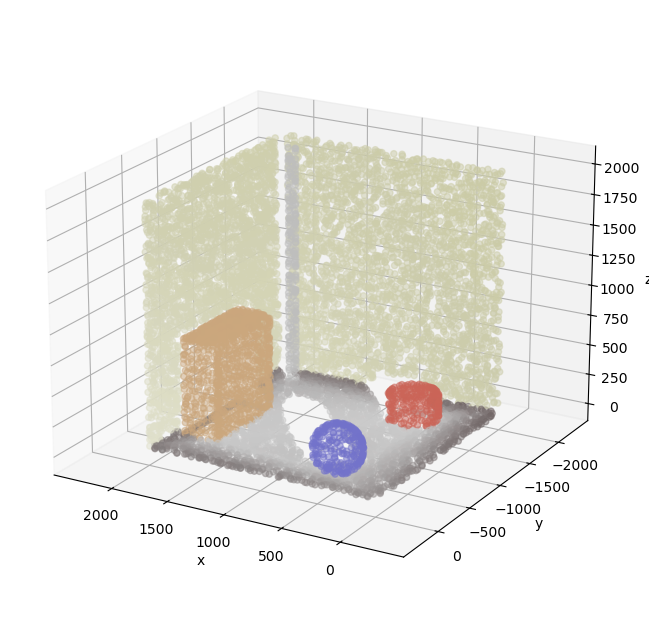

In [2]:
data = np.loadtxt("./data/indoor_scene.xyz")
#points, normals = data[:, :3], data[:, 3:]
points, colors = data[:, :3], data[:, 3:]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          c=colors, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20, 120)
plt.axis("equal")
plt.show()


## Region growing

The region growing algorithm is one quite popular segmentation algorithm, whether for images, pointclouds or meshes. It works by **iteratively aggregating similar points**, in a bottom-up fashion.

This algorithm is fairly simple, with just two main steps:
1. Creation of a region by the selection of a starting element (or *seed*).
2. Growth of this region by incorporating similar elements from its neighborhood.

The growth phase stops when the elements in the region's neighborhood can no longer be incorporated. The algorithm is usually repeated until every point of the pointcloud has been assigned to a region ($n$ repetitions resulting in $n$ regions).

Note that the algorithm requires the prior definition the notions of **similarity** and **neighborhood**. Numerous indicators may be used to assess similarity, alone or in combination, such as normals, colors, or local curvature. Similarly, the notion of neighborhood may take various definitions, such as k-nearest neighborhood, spherical neighborhood, or planar neighborhood.

An algorithm capable of segmenting a pointcloud into a set of smooth surface patches is for example described in the paper:

Rabbani, T., Van Den Heuvel, F., & Vosselmann, G. (2006). Segmentation of point clouds using smoothness constraint. *International archives of photogrammetry, remote sensing and spatial information sciences*, 36(5), 248-253.

This *smoothness constraint* "uses local surface normals and point connectivity which can be enforced using either k-nearest or fixed distance neighbors". The first is preferred by the authors for its adaptability to local point density.


In [3]:
kdtree = KDTree(points)
def neighbor_finding_function(x): return kdtree.query(x, k=20)[1]
# knn is used here
# for spherical neighborhood: return kdtree.query_ball_point(x, r=10.) 
    

According to the authors, normals are a good and reliable measure of local geometry, unlike principal curvatures and other high order geometrical descriptors which are more sensitive to noise. Normals are estimated by fitting a plane to the local neighborhood of a given point (see the next notebook for more details).

The residual of the plane fitting is taken as an approximation of the local curvature. Indeed, this value is equal to the sum of squared distances between the points and the fitted plane. Hence, the higher the residual, the more the surface sampled by the points deviate from a plane.

Note that both normals and residuals are affected by the kind and the size of the considered local neighborhood.


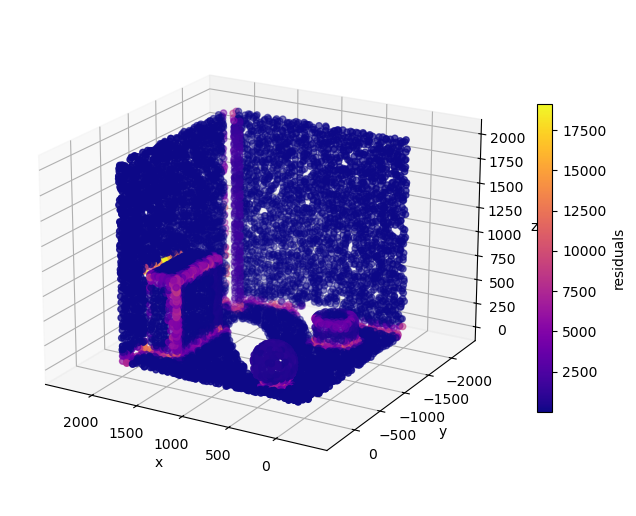

In [4]:
def compute_normals_residuals(points, neighbor_finding_function):

    normals = np.empty(points.shape, dtype=float)
    residuals = np.empty(len(points), dtype=float)

    # Local connectivity
    neighbors = neighbor_finding_function(points)
    # Local plane fitting
    for j, inds in enumerate(neighbors):    
        centroid = points[inds].mean(axis=0)
        X = points[inds] - centroid
        cov = X.T @ X
        w, v = np.linalg.eigh(cov)
        residuals[j] = w[0]
        normals[j] = v[:, 0] # eigenvectors are normalized

    return normals, residuals


# Compute and plot residuals
normals, residuals = compute_normals_residuals(points, neighbor_finding_function)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
p = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          c=residuals, cmap="plasma")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20, 120)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('residuals')
plt.axis("equal")
plt.show()
    

The estimated normals and residuals are then used for the region growing process:
1. The neighbor $p_j$ of $p_i$ is added to the growing region only if the cosine of the angle between their normals is over given threshold: $|n_i \cdot n_j| > \cos(\theta_{th})$
2. A neighbor of $p_j$ is considered a suitable candidate for the next steps of the growing phase only if its residual is below a given threshold: $r_j < r_{th}$

In the first expression, the absolute value of the dot product is taken due to inconsistent orientation between normals (normals are estimated with a 180° ambiguity). Normals are also supposed to be unit vectors.

The authors of the article propose to use an absolute value for $\theta_{th}$ and a relative value for $r_{th}$, which is a less intuitive parameter.


In [5]:
# Angle threshold (in degrees)
angle_threshold = 15.
# Residual threshold (as a percentile of the plane residuals)
residual_threshold = np.percentile(residuals, 95)


Once the neighborhood and thresholds have been defined and the normals and residuals have been approximated, the region growing phase may begin. The seed is here chosen as the not-already-segmented point with the minimum residual and the growth phase is realized according to the angular and residual conditions described above.

The process stops when each point of the pointcloud has been attributed to a segment/region.


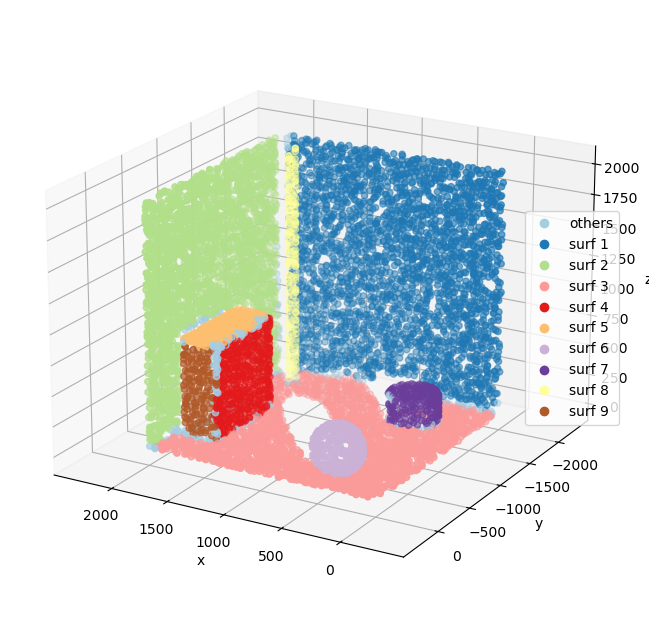

In [6]:
def region_growing(points, normals, residuals, neighbor_finding_function, angle_threshold, residual_threshold):
    
    # All points are available at start
    available_points = np.ones(len(points), dtype=bool)
    regions = []

    while available_points.any():
    
        # Current region is empty
        current_region = np.zeros(len(points), dtype=bool)
        # Point (index) with minimal residual is chosen as seed
        remaining_points = np.flatnonzero(available_points)
        seed = remaining_points[np.argmin(residuals[available_points])]
        current_seeds = [seed] # works as a queue
        # Remove seed from available points
        available_points[seed] = False
        # Include seed to current region
        current_region[seed] = True
    
        while len(current_seeds):        
            # Find nearest neighbors of current seed point
            seed = current_seeds.pop(0)
            neighbors = neighbor_finding_function(points[seed])
            
            for neighbor in neighbors:
                
                # Neighbors with orientation close to the seed are added to the current region
                abs_cos = np.abs(normals[neighbor] @ normals[seed]).clip(0., 1.) # absolute value because normals have a 180° ambiguity 
                angle = np.arccos(abs_cos) * 180/np.pi # in degrees
                if available_points[neighbor] and (angle < angle_threshold):
                    current_region[neighbor] = True
                    available_points[neighbor] = False
                    
                    # Neighbors with small residuals are potential seeds
                    if residuals[neighbor] < residual_threshold:
                        current_seeds.append(neighbor)
    
        regions.append(np.flatnonzero(current_region))

    return sorted(regions, key=len, reverse=True) # sort according to region size


# Segment pointcloud using region growing
regions = region_growing(points, normals, residuals, neighbor_finding_function, angle_threshold, residual_threshold)    

# Attribute a label to each point (number of attributed region)
labels = np.zeros(len(points))
for i, r in enumerate(regions):
    if len(r) < 100: break # disregard small regions for vizualisation purpose
    labels[r] = i + 1
classes = ["surf {}".format(i) for i in range(len(np.unique(labels)))]
classes[0] = "others"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
s = ax.scatter(points[:, 0], points[:, 1], points[:,2],
               c=labels, cmap="Paired")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right", handles=s.legend_elements()[0], labels=classes)
ax.view_init(20, 120)
plt.axis("equal")
plt.show()


Here, small neighborhoods and small thresholds (i.e., small values of $\theta_{th}$ and $r_{th}$) would likely lead to over-segmentation (i.e., more segmented surfaces), and vice-versa.

In a nutshell, the region-growth algorithm is relatively simple to conceptualize and implement. However, its results depend on the a priori definition of a neighborhoods and similarity criteria. Its parameters (size of the neighborhood and thresholds used to define the notion of similarity) need to be adjusted according to the context (pointcloud density, presence of noise, etc.).


## RANSAC

The Random sample consensus (RANSAC) algorithm aims to estimate the parameters of a *model* from a dataset that contains outliers. It was introduced in the paper:

Fischler, M. A., & Bolles, R. C. (1981). Random sample consensus: a paradigm for model fitting with applications to image analysis and automated cartography. *Communications of the ACM*, 24(6), 381-395.

The basic algorithm consists in two steps, that are iteratively repeated:
1. Randomly draw a sample of minimum but sufficient size from the dataset to build a candidate model
2. Compute the score of this candidate model by estimating the number of elements of the dataset that are consistent with it

The best candidate model is kept after a given number of iterations.

The RANSAC algorithm has many applications, including finding geometrical shapes in pointclouds. As for models (in general), these shapes have parameters and a measure of "how far" they are from the data points.

Let's consider an infinite planar surface for the sake of the example. It can be described by its cartesian equation $a.x + b.y + c.z + d = 0$ ($a$, $b$, $c$, and $d$ being the parameters of the plane). These parameters may be estimated using 3 points only: $n = [a, b, c] = (p_1 - p_0) \times (p_2 - p_0)$ and $d = - p_i \cdot n, \quad i = 0, 1, 2$. The distance between a point $p$ and the plane is given by $d = | n \cdot p + d |$ with $|| n || = 1$.


In [7]:
class PlaneModel:

    min_sample_size = 3
    
    def __init__(self):

        self.parameters = [1., 0., 0., 0.] # a.x + b.y + c.z + d

    def estimate_parameters(self, points):

        v1, v2 = points[1, :] - points[0, :], points[2, :] - points[0, :]
        self.parameters[:3] = np.cross(v1, v2) / np.linalg.norm(np.cross(v1, v2))
        self.parameters[-1] = - points[0, :] @ self.parameters[:3]

    def compute_distance(self, points):

        return np.abs(points @ self.parameters[:3] + self.parameters[-1])

    

A given number of candidate planes are evaluated before the best candidate is returned. Inliers are defined as points within a certain distance (threshold) to a candidate plane.

The algorithm then is usually repeated a certain number of times in order to detect all shapes present in the pointcloud.


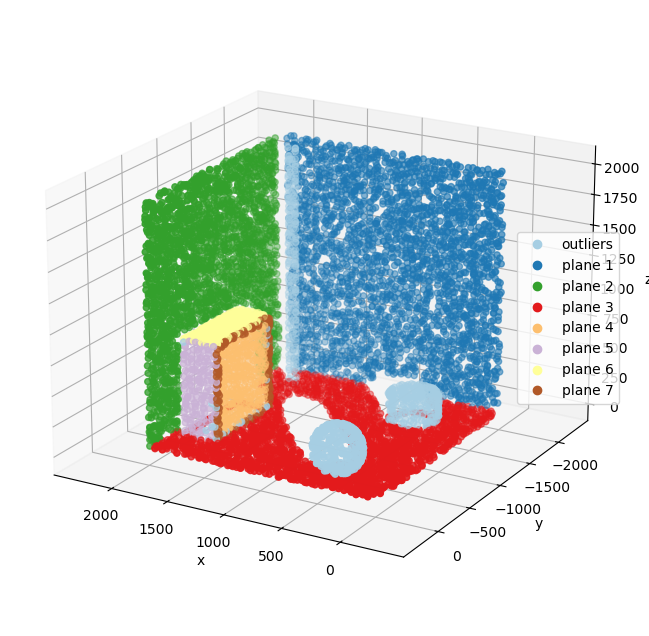

In [8]:
def RANSAC(points, model, n_draws, threshold):

    best_score = 0
    best_model = None
    best_inliers = None

    for _ in range(n_draws):
        # Random sampling
        sampled_inds = np.random.choice(len(points), size=model.min_sample_size, replace=False)
        sampled_points = points[sampled_inds]
        # Candidate plane
        candidate = model()
        candidate.estimate_parameters(sampled_points)
        # Inliers
        dists = candidate.compute_distance(points)
        inliers = np.flatnonzero(dists < threshold)
        # Score
        score = len(inliers)
        # Keep best candidate
        if score > best_score:
            best_score = score
            best_model = candidate
            best_inliers = inliers

    return best_model, best_score, best_inliers


# Run RANSAC for planar surfaces
max_number_of_runs = 100
min_points_per_region = 100 # disregard small regions

all_regions = []
remaining_inds = np.arange(len(points), dtype=int)
for _ in range(max_number_of_runs):
    _, _, region = RANSAC(points[remaining_inds], PlaneModel, 100, .1)
    if len(region) > min_points_per_region:
        all_regions.append(remaining_inds[region])
        remaining_inds = np.setdiff1d(remaining_inds, remaining_inds[region])

# Attribute a label to each point (number of attributed region)
labels = np.zeros(len(points))
for i, r in enumerate(all_regions):
    labels[r] = i+1
classes = ["plane {}".format(i) for i in range(len(np.unique(labels)))]
classes[0] = "outliers"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
s = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
              c=labels, cmap="Paired")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right", handles=s.legend_elements()[0], labels=classes)
ax.view_init(20, 120)
plt.axis("equal")
plt.show()


As seen above, the algorithm successfully detect planar surfaces in the pointcloud. Again, the parameters of the algorithm can be adjusted according to the segmentation result: a small number of repetitions and a small value of the distance threshold would likely lead to under-segmentation, and vice-versa.

The above example describes a very simple implementation of the RANSAC algorithm, but many proposals have been made to improve its the behavior in the context of shape detection in pointclouds. Some major ones are described in the article:

Schnabel, R., Wahl, R., & Klein, R. (2007, June). Efficient RANSAC for point‐cloud shape detection. In *Computer graphics forum* (Vol. 26, No. 2, pp. 214-226). Oxford, UK: Blackwell Publishing Ltd.

Covered aspects include shape estimation (i.e., the process of estimating the parameters of planes, cylinders, spheres, cones and tori from minimal sets of oriented points), complexity (i.e., the number of candidates required to detect shapes with sufficient probability), sampling strategy, scoring (using a distance threshold but also an angular threshold and taking points connectivity into account), and refitting.

More generally, the popularity of the RANSAC algorithm for shapes detection in pointclouds lies in its simplicity, extensibility to a wide variety of shapes (as long as an estimation function from a minimal set of points and a distance function are available) and robustness to the presence of outliers. However, it is quite computationally demanding and non-deterministic (i.e., different runs may give different results).

